# Lab Part 2
1. Write a function to calculate included angle from two vectors
2. Identify gait speed vs. time
3. Identify ankle height vs. time (R, L)
4. Identify knee angle vs. time (R, L)
5. Set up pandas dataframe with outcome variables
6. Code rows in dataframe by participant
7. Plot the data

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install validators
!pip install validators

In [3]:
# imports etc.
import validators
from pathlib import Path
import os
import urllib.request
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

### Base functions for interacting with .json files

The following routines allow you to load and make a basic plot of a `.json` file from OpenPose.

In [4]:
def extract_kp_from_resource(f,person_id = -1):
    """
    Extract keypoints from resource (file or url) as a numpy vector
    """

    # load json from remote if it is an url; otherwise load as file
    if validators.url(f):
        json_temp = json.load(urllib.request.urlopen(u))['people']
    if Path(f).exists():
        json_temp = json.load(open(f))['people']
    
    try:
        # extract the keypoints of the person specified by person_id; default is last person identified
        keypoints = np.array(extract_kp_from_json(json_temp)["pose_keypoints_2d"][person_id]).astype('float')
    except:
        keypoints = np.empty((75,))
        keypoints[:] = np.NaN
    
    # set missing points (imputed as 0) to nan so that they are not plotted
    keypoints[keypoints==0] = np.nan
    
    return keypoints

def extract_kp_from_json(json_people):
    """
    subfunction for extract_kp_from_resource
    """
    person_id = []
    pose_keypoints_2d = []
    for i in range(0,len(json_people)):
        person_id.append(json_people[i]["person_id"])
        pose_keypoints_2d.append(json_people[i]["pose_keypoints_2d"])
    # return a dict
    return {'person_id': person_id, 'pose_keypoints_2d': pose_keypoints_2d}

def convert_kp_to_df(keypoints):
    """
    reshape keypoint vector to dataframe
    """
    # reshape to 25 X 3; the coordinates are x, y, confidence in estimate
    kin = keypoints.reshape((-1,3))
        
    # create a dataframe
    df = pd.DataFrame({'keypoint': ["Nose", "Neck", "RShoulder", "RElbow", "RWrist", "LShoulder", "LElbow", "LWrist", "MidHip", 
                                    "RHip", "RKnee", "RAnkle", "LHip", "LKnee", "LAnkle", "REye", "LEye", "REar", "LEar", "LBigToe", 
                                    "LSmallToe", "LHeel", "RBigToe", "RSmallToe", "RHeel"], 'x': kin[:,0], 'y': kin[:,1], 'confidence': kin[:,2]})

    return df.set_index('keypoint')

def plot_body25_df(df):
    """
    plot a dataframe corresponding to body25 coordinates
    """
    segments = [['Neck', 'REar', 'LEar', 'Neck'],
        ['Nose', 'REye', 'LEye', 'Nose'],
        ['RShoulder', 'Neck', 'LShoulder','RShoulder'],
        ["LShoulder", "LElbow", "LWrist"],
        ["RShoulder", "RElbow", "RWrist"],
        ['RShoulder', 'RHip', 'LHip','LShoulder','RShoulder'],
        ['LHip', 'MidHip', 'RHip'],
        ["LHip", "LKnee", "LAnkle"],
        ["RHip", "RKnee", "RAnkle"],
        ['LAnkle', 'LHeel', 'LBigToe', 'LSmallToe', 'LAnkle'],
        ['RAnkle', 'RHeel', 'RBigToe', 'RSmallToe', 'RAnkle']]
    
    fig, ax = plt.subplots()
    ax.set(xlim=[0, 1920], ylim=[1080, 0], xlabel='X', ylabel='Y')
    [sns.lineplot(data=df.loc[s].reset_index(), x = "x", y = "y", ax = ax) for s in segments]

### Sample load and plot

Here is a sample of how to load/plot from a local file or online resource

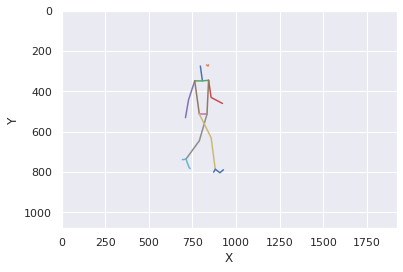

In [5]:
u = "https://jlucasmckay.bmi.emory.edu/global/bmi500/keypoints.json"
f = "/content/drive/MyDrive/keypoints.json"

kp_u = extract_kp_from_resource(u)
kp_f = extract_kp_from_resource(f)

df_u = convert_kp_to_df(kp_u)
df_f = convert_kp_to_df(kp_f)

plot_body25_df(df_f)

### Functions to calculate outcomes
 
To complete the lab, you must fill in the following function prototypes:

```python
def calculate_angle(v1,v2):
    """
    return the angle (in degrees) between two vectors v1 and v2.
    """
    
def df_to_outcomes(d):
    """
    return a dataframe with kinematic outcomes derived from a single body25 dataframe.
    """
        
def calc_outcomes(f):
    """
    calculate outcomes from a file or other resource
    return as a dataframe in standard format
    """
```

In [6]:
def calculate_angle(v1,v2):
    """
    return the angle (in degrees) between two vectors v1 and v2.
    """

    # Dot product
    num = np.dot(v1, v2)
    # Multiplication magnitude vectors
    den = np.linalg.norm(v1)*np.linalg.norm(v2)
    # Angle in degrees
    angle = np.arccos(num/den) * (180/np.pi)

    return angle
    
def df_to_outcomes(d):
    """
    return a dataframe with kinematic outcomes derived from a single body25 dataframe.
    """

    # Create vectors for right knee angle calculations
    if(np.isnan(d.loc['RHip', 'x']) or np.isnan(d.loc['RKnee', 'x']) or np.isnan(d.loc['RAnkle', 'x'])):
      r_knee_ang = ''
    else:
      v1 = [d.loc['RHip', 'x'] - d.loc['RKnee', 'x'], d.loc['RHip', 'y'] - d.loc['RKnee', 'y']]
      v2 = [d.loc['RAnkle', 'x'] - d.loc['RKnee', 'x'], d.loc['RAnkle', 'y'] - d.loc['RKnee', 'y']]
      r_knee_ang = calculate_angle(v1,v2)
    # Create vectors for left knee angle calculations
    if(np.isnan(d.loc['LHip', 'x']) or np.isnan(d.loc['LKnee', 'x']) or np.isnan(d.loc['LAnkle', 'x'])):
      l_knee_ang = ''
    else:
      v1 = [d.loc['LHip', 'x'] - d.loc['LKnee', 'x'], d.loc['LHip', 'y'] - d.loc['LKnee', 'y']]
      v2 = [d.loc['LAnkle', 'x'] - d.loc['LKnee', 'x'], d.loc['LAnkle', 'y'] - d.loc['LKnee', 'y']]
      l_knee_ang = calculate_angle(v1,v2)
    # Right toe height calculation
    if(np.isnan(d.loc['RBigToe', 'y']) or np.isnan(d.loc['RSmallToe', 'y'])):
      r_toe_ht = ''
    else:
      r_toe_ht = (d.loc['RBigToe', 'y'] + d.loc['RSmallToe', 'y'])/2
    # Left toe height calculation
    if(np.isnan(d.loc['LBigToe', 'y']) or np.isnan(d.loc['LSmallToe', 'y'])):
      l_toe_ht = ''
    else:
      l_toe_ht = (d.loc['LBigToe', 'y'] + d.loc['LSmallToe', 'y'])/2
    # Center of the trunk segment calculation
    if(np.isnan(d.loc['Neck', 'x']) or np.isnan(d.loc['MidHip', 'x']) or np.isnan(d.loc['Neck', 'y']) or np.isnan(d.loc['MidHip', 'y'])):
      com_x = ''
      com_y = ''
    else:
      com_x = (d.loc['Neck', 'x'] + d.loc['MidHip', 'x'])/2
      com_y = (d.loc['Neck', 'y'] + d.loc['MidHip', 'y'])/2 

    # Create dataframe
    results = {'r_knee_ang':r_knee_ang, 'l_knee_ang':l_knee_ang, 'r_toe_ht':r_toe_ht,
                'l_toe_ht':l_toe_ht, 'com_x':com_x, 'com_y':com_y}
    results_dt = pd.DataFrame(results, index=[0])

    return results_dt
         
def calc_outcomes(f):
    """
    calculate outcomes from a file or other resource
    return as a dataframe in standard format
    """

    kp_f = extract_kp_from_resource(f)
    df_f = convert_kp_to_df(kp_f)

    return df_f

### Loop over files

Next, you must loop over files in the `json/` directory and concatenate all of the outcomes into a pandas dataframe called `outcomes`.

In [7]:
# Define path
json_dir = Path('/content/drive/MyDrive/json')
files = list(json_dir.glob('*/*.json'))
# Initialize list
outcomes_list = []
# Iterate thoruth all the files
for filename in files:
  # Define trial and frame
  trial = filename.parent.stem
  frame = filename.name.split('_')[1]
  # Call calc_outcomes
  df = calc_outcomes(str(filename))
  # Call df_to_outcomes
  ind_outcomes = df_to_outcomes(df)
  # Add trial and frame to dataframe
  ind_outcomes['trial'] = trial
  ind_outcomes['frame'] = int(frame)
  # Append to list
  outcomes_list.append(ind_outcomes)
# Create final dataframe
outcomes = pd.concat(outcomes_list, ignore_index=True)

### Write to file

Write the data to a `csv` file

In [8]:
# Write to CSV file
outcomes.to_csv("/content/drive/MyDrive/HW13/outcomes.csv", index=False)

### Plot and save
Normal gait (right knee angle, first 200 frames)

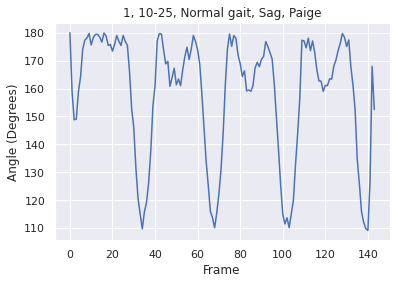

In [9]:
# Reduced dataframe
filtered_outcomes = outcomes.loc[outcomes['trial'] == '1, 10-25, Normal gait, Sag, Paige'] 
filtered_outcomes = filtered_outcomes.loc[outcomes['r_knee_ang'] != ''] 
# Select first 200 frames
if (filtered_outcomes.shape[0] > 200):
  filtered_outcomes = filtered_outcomes.iloc[:200] 
# Sort by frames
filtered_outcomes = filtered_outcomes.sort_values(by=['frame'])
plt.plot(range(filtered_outcomes.shape[0]), filtered_outcomes['r_knee_ang'])
plt.title('1, 10-25, Normal gait, Sag, Paige')
plt.xlabel('Frame')
plt.ylabel('Angle (Degrees)')
plt.savefig('/content/drive/MyDrive/HW13/1_10_25_Normal_gait_Sag_Paige.png')

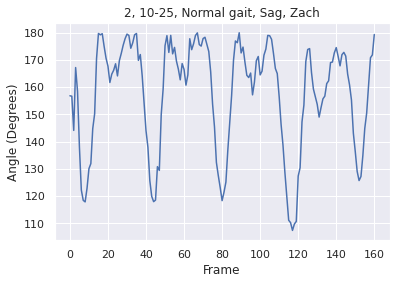

In [10]:
# Reduced dataframe
filtered_outcomes = outcomes.loc[outcomes['trial'] == '2, 10-25, Normal gait, Sag, Zach'] 
filtered_outcomes = filtered_outcomes.loc[outcomes['r_knee_ang'] != ''] 
# Select first 200 frames
if (filtered_outcomes.shape[0] > 200):
  filtered_outcomes = filtered_outcomes.iloc[:200] 
# Sort by frames
filtered_outcomes = filtered_outcomes.sort_values(by=['frame'])
plt.plot(range(filtered_outcomes.shape[0]), filtered_outcomes['r_knee_ang'])
plt.title('2, 10-25, Normal gait, Sag, Zach')
plt.xlabel('Frame')
plt.ylabel('Angle (Degrees)')
plt.savefig('/content/drive/MyDrive/HW13/2_10_25_Normal_gait_Sag_Zach.png')

Vaulting gait (right knee angle, first 200 frames)

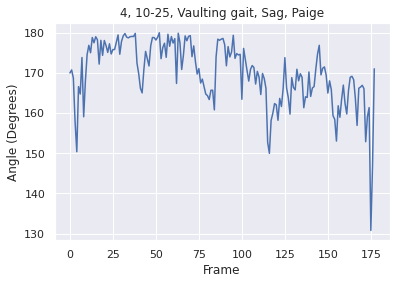

In [11]:
# Reduced dataframe
filtered_outcomes = outcomes.loc[outcomes['trial'] == '4, 10-25, Vaulting gait, Sag, Paige'] 
filtered_outcomes = filtered_outcomes.loc[outcomes['r_knee_ang'] != ''] 
# Select first 200 frames
if (filtered_outcomes.shape[0] > 200):
  filtered_outcomes = filtered_outcomes.iloc[:200] 
# Sort by frames
filtered_outcomes = filtered_outcomes.sort_values(by=['frame'])
plt.plot(range(filtered_outcomes.shape[0]), filtered_outcomes['r_knee_ang'])
plt.title('4, 10-25, Vaulting gait, Sag, Paige')
plt.xlabel('Frame')
plt.ylabel('Angle (Degrees)')
plt.savefig('/content/drive/MyDrive/HW13/4_10_25_Vaulting_gait_Sag_Paige.png')

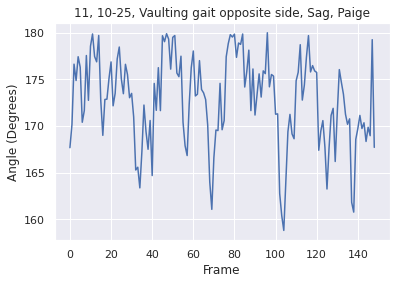

In [12]:
# Reduced dataframe
filtered_outcomes = outcomes.loc[outcomes['trial'] == '11, 10-25, Vaulting gait opposite side, Sag, Paige'] 
filtered_outcomes = filtered_outcomes.loc[outcomes['r_knee_ang'] != ''] 
# Select first 200 frames
if (filtered_outcomes.shape[0] > 200):
  filtered_outcomes = filtered_outcomes.iloc[:200] 
# Sort by frames
filtered_outcomes = filtered_outcomes.sort_values(by=['frame'])
plt.plot(range(filtered_outcomes.shape[0]), filtered_outcomes['r_knee_ang'])
plt.title('11, 10-25, Vaulting gait opposite side, Sag, Paige')
plt.xlabel('Frame')
plt.ylabel('Angle (Degrees)')
plt.savefig('/content/drive/MyDrive/HW13/11_10_25_Vaulting_gait_opposite_side_Sag_Paige.png')